In [1]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.datasets import text_classification

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  


#inference 
import en_core_web_sm
nlp = en_core_web_sm.load()

# Tokenizers
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer


C:\Users\Minyoung Na\anaconda\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize=None,tokenizer_language="en", lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [3]:
len(text_field.vocab)

31686

In [4]:
train

In [5]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out


In [6]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    state_dict = torch.load(load_path, map_location=device)
    model.load_state_dict(state_dict)
    
    return 


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [7]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = '',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                      labels = labels.to(device)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    torch.save(model.state_dict(), "model.pth")
                    save_metrics('metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics('metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [71/1420], Train Loss: 0.4567, Valid Loss: 4.5790
Model saved to ==> metrics.pt
Epoch [1/10], Step [142/1420], Train Loss: 1.4815, Valid Loss: 1.3691
Model saved to ==> metrics.pt
Epoch [2/10], Step [213/1420], Train Loss: 0.8229, Valid Loss: 0.8032
Model saved to ==> metrics.pt
Epoch [2/10], Step [284/1420], Train Loss: 0.7445, Valid Loss: 0.7125
Model saved to ==> metrics.pt
Epoch [3/10], Step [355/1420], Train Loss: 0.6429, Valid Loss: 0.6694
Model saved to ==> metrics.pt
Epoch [3/10], Step [426/1420], Train Loss: 0.6466, Valid Loss: 0.6344
Model saved to ==> metrics.pt
Epoch [4/10], Step [497/1420], Train Loss: 0.5067, Valid Loss: 0.6283
Model saved to ==> metrics.pt
Epoch [4/10], Step [568/1420], Train Loss: 0.5164, Valid Loss: 0.6162
Model saved to ==> metrics.pt
Epoch [5/10], Step [639/1420], Train Loss: 0.3686, Valid Loss: 0.6154
Model saved to ==> metrics.pt
Epoch [5/10], Step [710/1420], Train Loss: 0.3900, Valid Loss: 0.6022
Model saved to ==> metrics.pt
E

Model loaded from <== metrics.pt


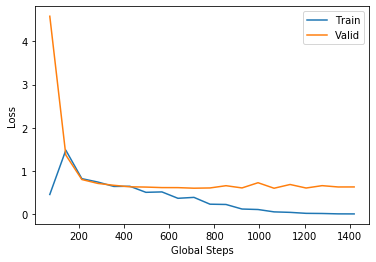

In [8]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Classification Report:
              precision    recall  f1-score   support

           1     0.7668    0.6933    0.7282       313
           0     0.7241    0.7925    0.7568       318

    accuracy                         0.7433       631
   macro avg     0.7455    0.7429    0.7425       631
weighted avg     0.7453    0.7433    0.7426       631



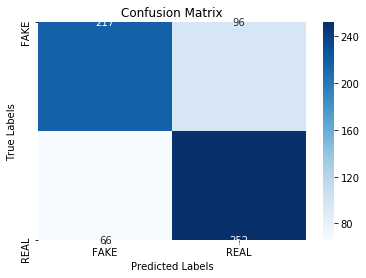

In [28]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.4):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
device = torch.device('cpu')
 
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

state_dict = torch.load('model.pth')
best_model.load_state_dict(state_dict)
    
    
evaluate(best_model, test_iter)

In [29]:
def predict(text, model):
    device = torch.device('cpu')
    tokenized = [tok.text for tok in nlp.tokenizer(text)]  #tokenize the sentence 
    indexed = [text_field.vocab[t] for t in tokenized]          #convert to integer sequence

    length = [len(indexed)]                                    #compute no. of words
    
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words

    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor , length_tensor)

    return prediction.item()

In [32]:
predict("Two key Republicans agree on national flood insurance WASHINGTON (Reuters) - Two senior U.S. House of Representatives Republicans said on Friday they have agreed on terms for the reauthorization of the deeply indebted National Flood Insurance Program. House Majority Whip Steve Scalise of Louisiana and House Financial Services Committee Chairman Jeb Hensarling of Texas said in a statement: ?쏷he bill we support will begin to make the flood insurance program more stable and sustainable for the people who count on it. We look forward to bringing this legislation to the House soon and urge our colleagues to support it.??They did not provide any details of the agreement. Lawmakers are wrestling with how to handle the flood insurance program?셲 expiration on Dec. 8. It is at least $24.6 billion in debt to the U.S. Treasury and likely to face billions of dollars in additional costs due to Hurricanes Harvey and Irma, which struck Texas and Florida in recent weeks. The program was extended 17 times between 2008 and 2012 and lapsed four times in that period. A 2012 law extended the program to September. In October the House and Senate approved $16 billion of funding to help the program cover claims from recent natural disasters after reaching its borrowing limit.",best_model)

0.7942935228347778

In [31]:
!tar -czf model.tar.gz model.pth code


In [13]:
class LLLL(nn.Module):

    def __init__(self, dimension=128):
        super(LLLL, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        out_forward = output[(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

best_model = torch.jit.script(LLLL())
torch.jit.save(best_model, 'scriptmodule.pt')
    
state_dict = torch.jit.load('scriptmodule.pt', map_location=torch.device('cpu'))
best_model.load_state_dict(state_dict)
    

ModuleAttributeError: 'RecursiveScriptModule' object has no attribute 'copy'

In [ ]:

def evaluate(model, test_loader, version='title', threshold=0.4):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    

    
evaluate(best_model, test_iter)